In [87]:
import numpy as np 
import pandas as pd

from collections import Counter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


In [88]:
from itertools import combinations
from scipy.stats import ttest_ind
import warnings
import random
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Добавим метод чтобы красиво отобржать текст
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [92]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [93]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [105]:
def first_look(df: pd.DataFrame, column: object, outlier_bounds: dict, descriptions: dict):
    '''
    Функция для осмотра переменных
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
    else:
        # Prepare plot data frame
        plot_df = pd.DataFrame({'Распределение': df[column]})
        if search_mistakes(df, column, outlier_bounds):
            low, high = IQR_outlier(df, column, verbose=False)
            plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,column].between(low, high)][column]
        # Draw plot
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")


def search_mistakes(df: pd.DataFrame, column: object, outlier_bounds: dict) -> bool:
    '''
    Функция проверяет переменные на наличие ошибок в данных
    '''
    if column not in list(outlier_bounds.keys()):
        low, high = IQR_outlier(df, column, verbose=False)
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('Найдены ошибки в количестве: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Выбросы не обнаружены')
    else:
        low, high = outlier_bounds[column][0], outlier_bounds[column][1]
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('Найдены выбросы по IQR в количестве: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Ошибки не обнаружены')
                    


def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)


def fill_na(df: pd.DataFrame, column: object, method='auto') -> pd.Series:
    '''
    Функция для заполнения пропущенных значений
    Варианты аргумента method:
    mode - заполнение наиболее частовстречаемым значением
    median - заполнение медианой
    density - случайное заполнение с учетом вероятности появления
    auto - для численных переменных медиана, для номинативных и смешанных density
    '''
    if method=='auto':
        if (df[column].dtypes == np.dtype('O')) and (df[column].nunique()<10):
            prob = df[column].value_counts(normalize=True)
            ind = df[df[column].isna()==True].index
            fill_list = pd.Series(random.choices(prob.index, prob, k=df[column].isna().sum()))
            fill_list.index = ind
            return df[column].fillna(fill_list)
        else:
            median = df[column].median()
            return df[column].fillna(median)
    elif method=='mode':
        mode = df[column].mode()[0]
        return df[column].fillna(mode)
    elif method=='median':
        median = df[column].median()
        return df[column].fillna(median) 
    elif method=='density': 
        prob = df[column].value_counts(normalize=True)
        ind = df[df[column].isna()==True].index
        fill_list = pd.Series(random.choices(prob.index, prob, k=df[column].isna().sum()))
        fill_list.index = ind
        return df[column].fillna(fill_list)
    else:
        raise  NameError('method может принимать следующие значения: mode, median, density, auto')

        
def get_boxplot(df: pd.DataFrame, column: object, ax_y='Rating') -> None:
    '''
    Функция для отображения boxplot-графиков для номинативных и смешанных переменных
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    cnt = df[column].value_counts()
    medians = stud_df.groupby([column])[ax_y].median()
    vertical_offset = stud_df.groupby([column])[ax_y].median() * 0.12
    x=stud_df[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick], 
                    horizontalalignment='center',size=15, color='w',weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()



def get_stat_dif(df: pd.DataFrame, column: object, target='Rating') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(), 
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

In [5]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
#Проверим датасет на наличие дубликатов:
if len(data)>len(data.drop_duplicates()):
    print('Дубликаты есть')
    display(data[data.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [10]:
# Посмотрим как распеделены пропуски по датасету:
#plt.figure(figsize=(10, 7))# размер тепловой карты
#sns.heatmap(data.isnull(), cmap="YlGnBu", annot=True);

#долго работает, видимо пригоден для не больших датасетов

In [11]:
# Проверим какое максимальное количество пропусков в строке:
Count_rows = data.apply(lambda x: sum(x.isnull()), axis=1).value_counts()
percent_nans=round(pd.Series(Count_rows.index/data.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(data.apply(lambda x: sum(x.isnull()), axis=1))/data.shape[1]
print('Максимум незаполненных строк в датафрейме:', round(misses*100, 2), "%")
pd.DataFrame({'Количество случаев в строке': Count_rows, 
              'Количество пропусков в строке': Count_rows.index,
              'Процент незаполненных значений в строке': percent_nans}).sort_values('Количество пропусков в строке', ascending=False).reset_index().drop('index',axis=1)

Максимум незаполненных строк в датафрейме: 36.36 %


,Количество случаев в строке,Количество пропусков в строке,Процент незаполненных значений в строке
0,1,4,36.0 %
1,1710,3,27.0 %
2,5341,2,18.0 %
3,10839,1,9.0 %
4,32109,0,0.0 %


In [15]:
data.shape

(50000, 11)

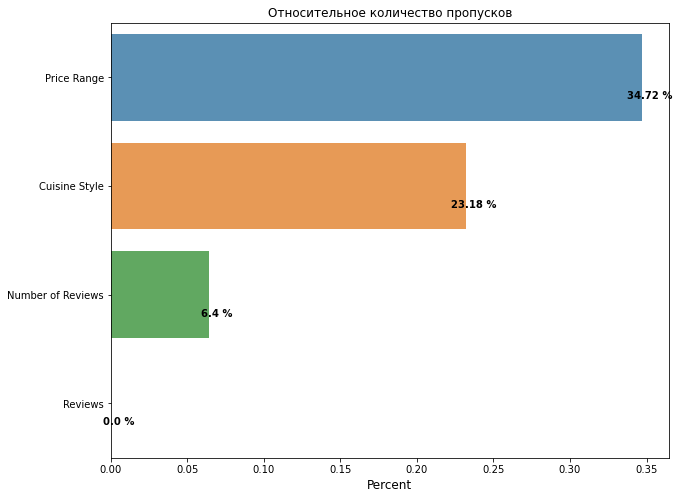

In [16]:
# Считаем процент пропусков
per_nans = pd.DataFrame(1-data.count()/data.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
# Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

In [17]:
data.describe()

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


<AxesSubplot:ylabel='Frequency'>

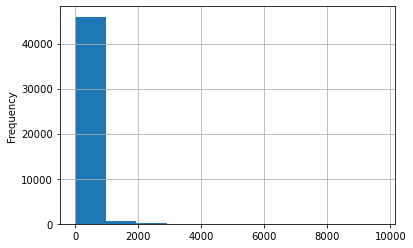

In [19]:
data['Number of Reviews'].plot(kind = 'hist', grid = True)

In [21]:
data[data['Number of Reviews'] > 2000].count()

Restaurant_id        171
City                 171
Cuisine Style        171
Ranking              171
Price Range          170
Number of Reviews    171
Reviews              171
URL_TA               171
ID_TA                171
sample               171
Rating               171
dtype: int64

In [69]:
data[data['Number of Reviews'] < 400].count()

Restaurant_id        46489
City                 46489
Cuisine Style        34905
Ranking              46489
Price Range          29146
Number of Reviews    46489
Reviews              46487
URL_TA               46489
ID_TA                46489
sample               46489
Rating               46489
reviews_cat          46489
dtype: int64

In [28]:
data[data['Number of Reviews'] < 50].count()

Restaurant_id        27400
City                 27400
Cuisine Style        17879
Ranking              27400
Price Range          13255
Number of Reviews    27400
Reviews              27399
URL_TA               27400
ID_TA                27400
sample               27400
Rating               27400
dtype: int64

In [29]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

In [30]:
def replace_nom(column):
    data[column] = data[column].apply(
        lambda x: 0 if x == '$'
        else 1 if x == '$$ - $$$'
        else 2 if x == '$$$$'
        else x
    )

In [31]:
for col in data:
    replace_nom(col)

<AxesSubplot:xlabel='Price Range', ylabel='Number of Reviews'>

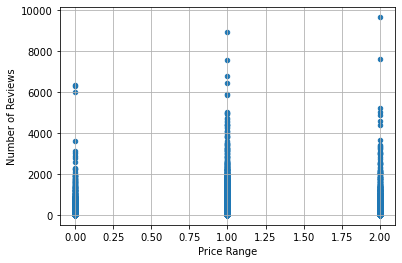

In [32]:
data.plot(x='Price Range', y='Number of Reviews', kind='scatter', grid=True)

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\negat\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

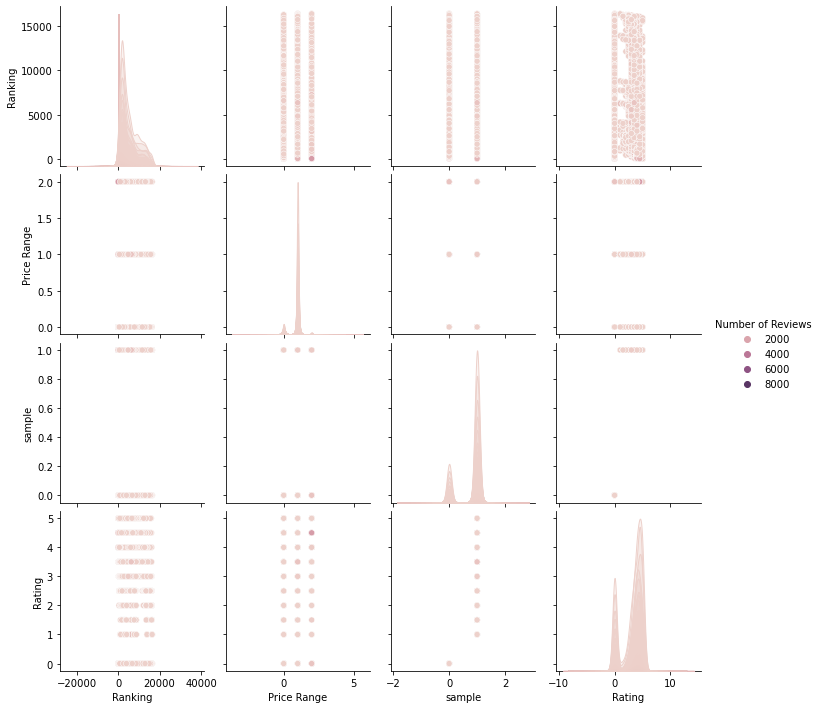

In [33]:
sns.pairplot(data, hue = 'Number of Reviews')

In [37]:
#for col in data.columns:
#    first_look(data)

TypeError: first_look() missing 3 required positional arguments: 'column', 'outlier_bounds', and 'descriptions'

In [ ]:
#пробуем обработать значения 'Number of Reviews'

In [62]:
data['Number of Reviews'].fillna(0, inplace=True)

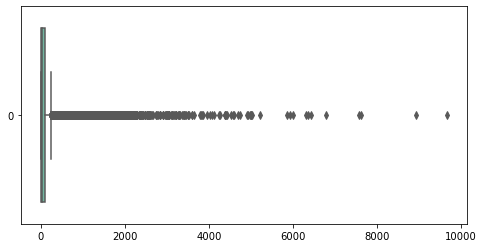

In [50]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data['Number of Reviews'], orient="h",
                 palette="Set2", whis=1.5);

In [63]:
data['reviews_cat'] = data['Number of Reviews'].apply(lambda x: 0 if x<400 else 1)

In [57]:
data['reviews_cat']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    1
49997    0
49998    0
49999    0
Name: reviews_cat, Length: 50000, dtype: int64

In [64]:
data['Number of Reviews'] = data['Number of Reviews'].apply(lambda x: 400 if x>400 else x)

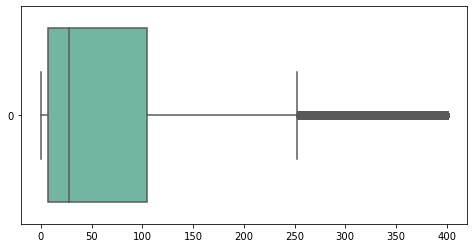

In [65]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data['Number of Reviews'], orient="h",
                 palette="Set2", whis=1.5);

In [70]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,reviews_cat
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,0
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,400.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,1
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,0
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,0


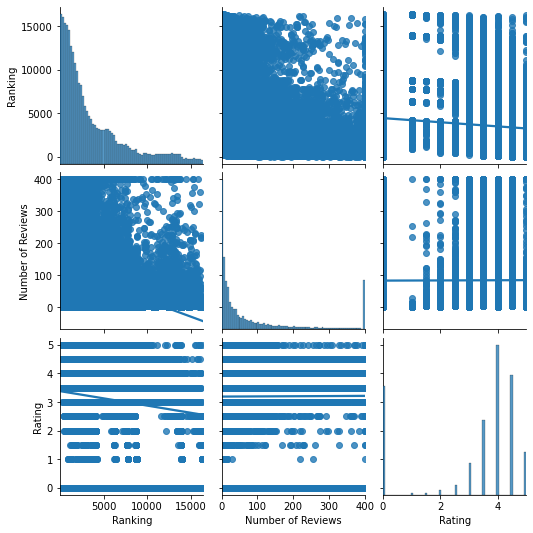

In [71]:
data_num = ['Ranking', 'Number of Reviews', 'Rating']
sns.pairplot(data[data_num], kind='reg');

In [72]:
data[data_num].corr()

,Ranking,Number of Reviews,Rating
Ranking,1.000000,-0.314966,-0.109897
Number of Reviews,-0.314966,1.000000,0.004052
Rating,-0.109897,0.004052,1.000000


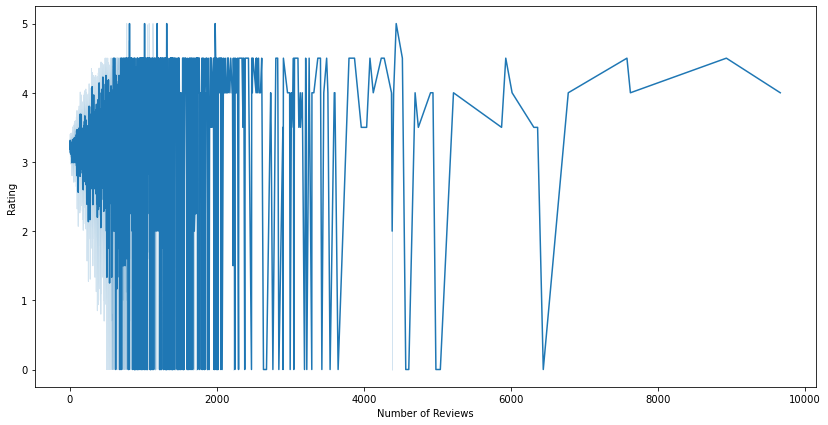

In [77]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=data, x='Number of Reviews', y='Rating');

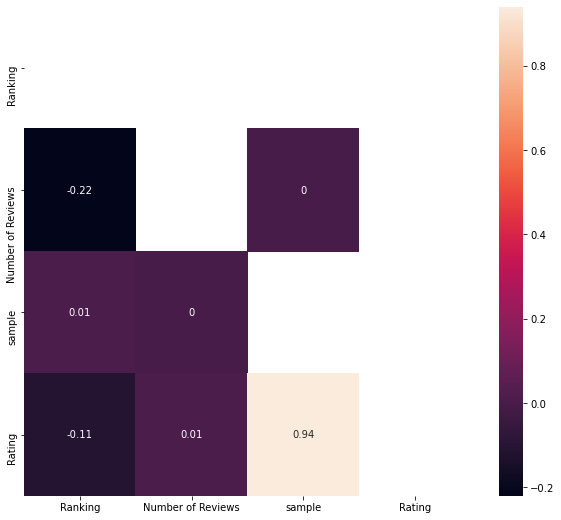

In [78]:
# Используем тепловую карту для удобства:
quantitative_features = data.select_dtypes(include='number').columns
corr_matrix = data[quantitative_features].corr().round(2)
plt.rcParams['figure.figsize'] = (10, 9)
matrix =  np.triu(corr_matrix)
x = sns.heatmap(corr_matrix, mask=matrix, annot=True)

In [80]:
score_correlation_df = pd.DataFrame(data.corr()["Rating"].values,
                                    index=data.corr()["Rating"].index,
                                    columns=['correlation'])
score_correlation_df = score_correlation_df.drop("Rating")

score_correlation_df['corellation_amount'] = abs(
    score_correlation_df.correlation)
#printmd("#### Кореллирующие значения в порядке убывания")
score_correlation_df.sort_values(by='corellation_amount', ascending=False)

,correlation,corellation_amount
sample,0.936543,0.936543
Ranking,-0.109897,0.109897
Number of Reviews,0.011472,0.011472


In [84]:
#слишком долго работаем
#nom_cols = list(set(data.columns) - set(['Ranking', 'Number of Reviews', 'Rating']))
#for col in nom_cols:
#    get_boxplot(data, col)

NameError: name 'stud_df' is not defined

Error in callback <function flush_figures at 0x000001C862791430> (for post_execute):


KeyboardInterrupt: 

In [91]:
nom_cols = list(set(data.columns) - set(['Ranking', 'Number of Reviews', 'Rating']))
lst = []
for col in nom_cols:
    if get_stat_dif(data, col):
        lst.append(col)

Найдены статистически значимые различия для колонки Cuisine Style
Найдены статистически значимые различия для колонки sample
Найдены статистически значимые различия для колонки Price Range
Найдены статистически значимые различия для колонки City


ЗАполняем пропуски!!!

In [97]:
data['Price Range'] = fill_na(data, 'Price Range', method='auto')

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [101]:
data['Price Range'].value_counts()

$$ - $$$    35250
$           12027
$$$$         2723
Name: Price Range, dtype: int64

In [102]:
data['Number of Reviews'] = fill_na(data, 'Number of Reviews', method='auto')

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  object 
 5   Number of Reviews  50000 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [ ]:
# Средняя цена в городе
#price_in_city_dict = df.groupby('City')['Price Range'].mean().to_dict()
#df['Price in City'] = df['City'].map(price_in_city_dict)

In [ ]:
# Сокращаем список кухонь для анализа до N - основных, остальные Other - это почти всегда дает улучшение предсказания
N=30 #!!!

s = df['Cuisine Style'].apply(lambda x: get_cuisines(x))
slist =[]
for x in s:
    slist.extend(x)
topNcusines = set(pd.Series(slist).value_counts()[:N].index)  
df['Cuisine top N'] =df['Cuisine Style'].apply(lambda x: is_cuisine_top_N(x))

In [ ]:
# Сетевой ID ресторана (похоже, что это ID франшизы, если повторяется более 1-го раза - isNetworkRestorant)
import warnings; warnings.simplefilter('ignore')
df['Restaurant_net_id'] = df['Restaurant_id'].apply(lambda x: x.split('_')[1])
NetworkRestorants = df[df['Restaurant_net_id'].isin(df['Restaurant_net_id'].value_counts()[df['Restaurant_net_id'].value_counts()>2].index)]
NetworkRestorants['isNetworkRestorant'] = True
df['isNetworkRestorant'] = NetworkRestorants['isNetworkRestorant']
df['isNetworkRestorant'] = df['isNetworkRestorant'].fillna(False)

In [ ]:
# Помечаем, входит ли город в N-top городов, если ДА, то пишем его назавние, если НЕТ -Other
top_Cityes = df['City'].value_counts()[0:10].index.to_list()
df['TopCityes'] = df.City.apply(lambda x: x if x in top_Cityes else 'Other_City')

In [ ]:
# Собираем Dummies: city, price_range, country_range, Cuisine top N

dff = pd.get_dummies(df['Cuisine top N'].apply(pd.Series).stack()).sum(level=0)
df_mcc = pd.get_dummies(df['Most Common Cusine in City'], prefix = 'MCC')
df_city = pd.get_dummies(df['City'], prefix = 'City Range')
#df_city = pd.get_dummies(df['TopCityes'], prefix = 'City', dummy_na=True)
df_price_range = pd.get_dummies(df['Price Range'], prefix = 'Price Range') 
df_country_range = pd.get_dummies(df['Country'], prefix = 'Country Range',) 
#df_season_range = pd.get_dummies(df['NewestReviewSeason'], prefix = 'Season',)

df['PositiveWordsList'] = df['PositiveWordsList'].fillna('NAN')
df_positive_words_range = pd.get_dummies(df['PositiveWordsList'].apply(pd.Series).stack(), dummy_na=False).sum(level=0)


df1 = pd.concat([df,dff], axis=1)
df1 = pd.concat([df1,df_city], axis=1)
df1 = pd.concat([df1,df_price_range], axis=1)
df1 = pd.concat([df1,df_country_range], axis=1)
df1 = pd.concat([df1,df_mcc], axis=1)
df1 = pd.concat([df1,df_positive_words_range], axis=1)

#df1 = pd.concat([df1,df_season_range], axis=1)

#df1 = pd.concat([df1,df_restid_range], axis=1)

cols_cuisine_style = dff.columns
cols_city = df_city.columns
cols_price_range =  df_price_range.columns
cols_country_range =  df_country_range.columns
cols_mcc =  df_mcc.columns
cols_positive_words = df_positive_words_range.columns
#cols_season = df_season_range.columns
#cols_restid_range =  df_restid_range.columns

Проверяем годность предсказаний

In [ ]:
print('Тренировочный датасет')
df[df.ForTrain].Rating.value_counts()

In [ ]:
print('Предсказания масштабированные в 4 раза')
submission_df.Rating.value_counts()*4

In [ ]:
def get_num_of_cuisine_styles_by_city(df):
    """Считает количество видов кухни по городам"""

    group_by_city = df.explode("Cuisine Style").groupby("City")[
        "Cuisine Style"]

    return group_by_city.aggregate(lambda x: len(set(x.values))).sort_values(ascending=False)

In [ ]:
def get_lowercase_words(s):
    """Функция оставляет только буквы и переводит их в строчные"""
    
    return [m[0].lower() for w in s.split(" ") for m in [re.findall(r"(\w+)", w)] if m]

In [ ]:
def get_value_of_words(words):
    """Определяет общее настроение слов, меньше нуля - негативное, больше - позитивное"""
    
    return sum([val for w in words for val in [word_evals.get(w)] if val is not None])

In [ ]:
def normalize(col):
    """Нормализует значение признака так, чтобы его значения были от -1 до 1"""
    
    center = col - col.mean()
    norm = np.sqrt((col ** 2).sum())
    return center / norm

In [ ]:
# исправим ошибку в названии города
data["City"].replace({"Oporto": "Porto"}, inplace=True)

# оставим признак City, т.к. в будущем он нам понадобится
data_dummies = pd.get_dummies(data, columns=["City"])
data = pd.concat([data["City"], data_dummies], axis=1)

In [ ]:
def get_dummies_from_lists(col, prefix):
    """
    Кодирует колонку, значения которой являются списками, с помощью объекта
    MultiLabelBinarizer библиотеки sklearn

    :param col: колонка, значения которой являются списками
    :param prefix: префикс, добавляемый перед каждой колонкой новых признаков
    :returns датафрейм, содержащий dummy значения
    """

    mlb = MultiLabelBinarizer()
    dummy_values = mlb.fit_transform(col)
    columns = prefix + "_" + mlb.classes_

    return pd.DataFrame(dummy_values, columns=columns).astype(np.uint8)

In [ ]:
# кодируем признак Cuisine Style в dummy значения
dummies = get_dummies_from_lists(data["Cuisine Style"], "Cuisine")
data = pd.concat([data, dummies], axis=1)

In [ ]:
# посмотрим, какое среднее значение количества отзывов в зависимости от города
mean_num_of_reviews = data.groupby(
    "City")["Number of Reviews"].mean().sort_values(ascending=False)
ax = sns.barplot(mean_num_of_reviews.index, mean_num_of_reviews)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
# добавим признак, означающий среднее количество отзывов в городе нахождения ресторана
new_feature_name = "Number of Reviews (mean by city)"
data[new_feature_name] = data["City"].apply(lambda x: mean_num_of_reviews[x])

In [ ]:
# посмотрим на часто встречающиеся слова у ресторанов с рейтигом от 3 и выше
plt.rcParams["figure.figsize"] = (10, 8)
show_wordcloud(get_text_from_reviews(data[data["Rating"] >= 3]))

In [ ]:
# create id_ta without d
data['ID_TA_n'] = data.ID_TA.apply(lambda x: x[1:]).astype(str).astype(int)

In [ ]:
# look at the ID_TA length 
data.ID_TA.apply(lambda x: len(x[1:])).hist(bins=5)

In [ ]:
 check what duplicates we have here
data.ID_TA.value_counts().unique()

In [ ]:
# create column with id_ta which has duplicates 
data['ID_TA_dup'] = dup_col(data.ID_TA)

In [ ]:
def dup_col(col):
        duplicated_col = col.value_counts().loc[lambda x: x>1].index.tolist()
        new_col = []
        for x in col:
            if x in duplicated_col:
                new_col.append(1)
            else:
                new_col.append(0)
        return new_col